# Overview

In today's exercise we'll build and train a simple a RNN from scratch using no libraries other than numpy.
Just like in the examples shown in yesterday's lecture, we'll train a character level language model.
That means our Rnn will receive a text as input and generate a possible continuation of the text sequence on symbol at a time.

In [1]:
import numpy as np #the only import statement you'll need today

## Input data
 
For now, we'll be using the complete works of shakespeare as our training corpus. You can download the text as one file from https://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt

Once you are finished with this exercise feel free to try out other training datasets.

In [2]:
data = open('input.txt', 'r').read() # we assume the file is a simple plain text file

character_to_id = { ch:i for i,ch in enumerate(set(data)) }
id_to_character = { i:ch for i,ch in enumerate(set(data)) }
dataset_size, vocab_size = len(data), len(character_to_id)
print(f'The dataset has a total of {dataset_size} characters, with {vocab_size} unique characters.')

The dataset has a total of 4573338 characters, with 67 unique characters.


## The Character-RNN Model

In the Lecture we had a look at how RNNs process a sequence of inputs by considering the input of the current time step and the hidden state of the previous time step.
 Let us take a look at how input and output look like in our simple RNN model.


![image.png]( 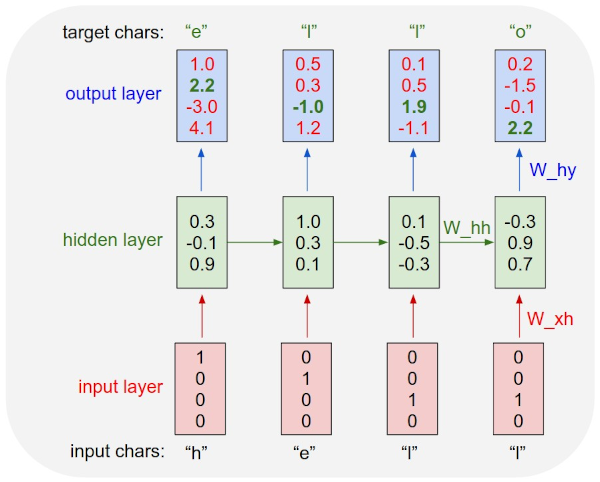)


As we can see, our output at each step is supposed to be the next character in the sequence. We can use this to train our model by comparing the predicted output to the actual output at each step. Our input is a simple one-hot encoded vector of the current character in the sequence. Our output is the probability distribution over all possible characters.

The important part is the hidden state, which is a representation of the sequence up to the current point. This hidden state is updated at each step using a learned transformation of the input and the previous hidden state. This allows the model to learn the structure of the sequence and make predictions based on the context of the sequence so far. For our implementation this means that we need the three Weight matrices W_xh, W_hh and W_hy shown in the figure above. We also need the biases bh and by. For simplicity, we will initialize these matrices randomly and the biases as zero. In the hidden layer, we will use the tanh activation function.

Since predicting the next character in the sequence is a classification problem, we can use the softmax function to convert the output of the model into a probability distribution over all possible characters. Finally, we can use the cross-entropy loss function to compare the predicted output to the actual output.

In the code below, fill in the following gaps in the implementation:
  - Initialize the model weights and biases
  - Implement the forward_step function, which performs a forward pass for a single timestep...
  - ... and the backward_step function, which performs a backward pass for a single timestep

In [46]:
class RNN:
  def __init__(self,hidden_size, character_to_id, id_to_character):
    self.character_to_id = character_to_id
    self.id_to_character = id_to_character
    self.vocab_size = len(character_to_id)
    self.hidden_size = hidden_size
    #you need to initialize the model weights and biases with the correct shapes
    self.Wxh = np.random.randn(hidden_size, self.vocab_size) * 0.01
    self.Whh = np.random.randn(hidden_size, hidden_size) * 0.01
    self.Why = np.random.randn(self.vocab_size, hidden_size) * 0.01
    self.bh = np.zeros((hidden_size, 1))
    self.by = np.zeros((self.vocab_size, 1))
    self.dWxh, self.dWhh, self.dWhy = np.zeros_like(self.Wxh), np.zeros_like(self.Whh), np.zeros_like(self.Why)
    self.dbh, self.dby = np.zeros_like(self.bh), np.zeros_like(self.by)

  def forward_step(self, x, h_prev):
    """
    Perform a single forward step of the RNN
    :param x: a one-hot encoded vector of the current character
    :param h_prev: the hidden state passed through by the previous step
    :return: The resulting numpy arrays:
    - h is the resulting hidden state
    - p, which contains the normalized probabilities for the next character
    """
    h = np.tanh(np.dot(self.Wxh, x) + np.dot(self.Whh, h_prev) + self.bh)
    logits = np.dot(self.Why, h) + self.by
    exp_logits = np.exp(logits)
    exp_logits -= np.max(exp_logits)
    p = np.exp(exp_logits) / np.sum(np.exp(exp_logits))
    return h, p

  def forward(self, inputs, hprev):
    """
    Perform a forward pass of the entire sequence. Use teacher forcing at all steps.
    :param inputs: a list of input characters
    :param hprev: the initial hidden state
    :return: the following lists
    - xs is a list of one-hot encodings for input characters
    - hs is a list of hidden states
    - ps is a list of normalized probabilities
    """
    # initialize empty lists of the right length
    # In this implementation, we'll treat timestep 0 as the initial hidden state,
    # i.e. it has no corresponding inputs and outputs
    xs, hs, ps = [None] * (len(inputs)), [None] * (len(inputs)), [None] * (len(inputs))
    hs[0] = np.copy(hprev)
    for t in range(1,len(inputs)):
        xs[t] = np.zeros((self.vocab_size,1))
        xs[t][inputs[t]] = 1
        hs[t],ps[t] = self.forward_step(xs[t], hs[t-1])
    return xs,hs,ps

  def cross_entropy_loss(self, p, target):
    """
    :param p: a np.array of predicted probabilities for a step
    :param target: the index of the target character
    :return: the loss at the current step
    """
    return -np.log(p[target,0])

  def backward_step(self, dy , h, x, hprev, dhnext):
      """
      Perform a single backward step of the RNN and update the following parameters,
      i.e.The gradients of the loss with respect to the model parameters
      - dWxh, dWhh, dWhy are the gradients of the loss with respect to the model parameters
      - dbh, dby are the gradients of the loss with respect to the biases
      :param dy: the gradient of the loss with respect to the unnormalized log probabilities
      :param h: the hidden state at the current step
      :param x: the input at the current step
      :param hprev: the hidden state at the previous timestep
      :param dhnext: the gradient of the loss flowing in backwards from the next timestep
      :return: dhnext is the gradient of the loss with respect to the previous hidden state
      """
      self.dWhy += np.dot(dy, h.T)
      self.dby += dy
      dh = np.dot(self.Why.T, dy) + dhnext
      dhraw = (1 - h * h) * dh
      self.dbh += dhraw
      self.dWxh += np.dot(dhraw, x.T)
      self.dWhh += np.dot(dhraw, hprev.T)
      dhnext = np.dot(self.Whh.T, dhraw)
      return dhnext

  def backwards(self, xs, ps, hs, targets):
    """
    Perform a backward pass of the entire RNN
    :param xs: a list of one-hot encodings for input characters
    :param hs: a list of hidden states
    :param ps: a list of normalized probabilities
    :param targets: a list of target characters
    :return: the following lists
    - dWxh, dWhh, dWhy, dbh, dby are the gradients of the loss with respect to the model parameters
    - dhnext is the gradient of the loss with respect to the initial hidden state
    """
    self.dWxh, self.dWhh, self.dWhy = np.zeros_like(self.Wxh), np.zeros_like(self.Whh), np.zeros_like(self.Why)
    self.dbh, self.dby = np.zeros_like(self.bh), np.zeros_like(self.by)
    dhnext = np.zeros_like(hs[0])
    for t in reversed(range(len(inputs))):
        if t == 0:
          #as before, index 0 only holds our initial hidden state
          break
        # We use a little trick to backpropagate through the softmax function and the cross-entropy loss at the same time
        dy = np.copy(ps[t])
        dy[targets[t]] -= 1
        # update the gradients ...
        dhnext = self.backward_step(dy, hs[t], xs[t], hs[t-1], dhnext)
    for dparam in [self.dWxh, self.dWhh, self.dWhy, self.dbh, self.dby]:
        np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
    return hs[len(inputs)-1]


  def sample(self, h, seed_ix, n):
    """
    This function generates readable outputs, used in logging while training the model
    You do not need to change this
    sample a sequence of integers from the model
    h is memory state, seed_ix is seed letter for first time step
    """
    x = np.zeros((vocab_size, 1))
    x[seed_ix] = 1
    ixes = []
    for t in range(n):
      h,p = self.forward_step(x,h)
      ix = np.random.choice(range(vocab_size), p=p.ravel())
      x = np.zeros((vocab_size, 1))
      x[ix] = 1
      ixes.append(ix)
    return ixes



## Testing the implementation

If everything is implemented correctly, you can run the code below to train the model and watch as it learns to generate random text in style of our training data


In [47]:
# hyperparameters
# Feel free to play around with the parameters
hidden_size = 100 # size of hidden layer of neurons
seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 1e-1

#intialize the model
rnn = RNN(hidden_size, character_to_id, id_to_character)

n, pos = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(rnn.Wxh), np.zeros_like(rnn.Whh), np.zeros_like(rnn.Why)
mbh, mby = np.zeros_like(rnn.bh), np.zeros_like(rnn.by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0

#Training loop
while True:
  # prepare inputs (we're sweeping from left to right in steps seq_length long)
  if pos+seq_length+1 >= len(data) or n == 0:
    hprev = np.zeros((hidden_size,1)) # reset RNN memory
    pos= 0 # go from start of data
  #We pad both lists once, so we can use index 0 for the initial hidden state
  inputs = [None] + [rnn.character_to_id[ch] for ch in data[pos:pos+seq_length]]
  targets = [None] + [rnn.character_to_id[ch] for ch in data[pos+1:pos+seq_length+1]]

  # sample from the model now and then
  if n % 100 == 0:
    sample_ix = rnn.sample(hprev, inputs[0], 200)
    txt = ''.join(rnn.id_to_character[ix] for ix in sample_ix)
    print(f'----\n {txt} \n----')

  # forward seq_length characters through the net and fetch gradient
  xs,hs,ps = rnn.forward(inputs, hprev)
  loss = 0
  for i in range(1,len(inputs)):
    p = ps[i]
    target = targets[i]
    loss += rnn.cross_entropy_loss(p, target)
  hprev = rnn.backwards(xs, ps, hs, targets)

  smooth_loss = smooth_loss * 0.999 + loss * 0.001

  if n % 100 == 0: print(f'iter {n} loss: {smooth_loss}')# print progress

  # perform parameter update with Adagrad
  for param, dparam, mem in zip([rnn.Wxh, rnn.Whh, rnn.Why, rnn.bh, rnn.by],
                                [rnn.dWxh, rnn.dWhh, rnn.dWhy, rnn.dbh, rnn.dby],
                                [mWxh, mWhh, mWhy, mbh, mby]):
    mem += dparam * dparam
    param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update
    #check for nan in any param
  if np.isnan(np.sum(param)):
    print(f'nan in param {param}')
    break

  pos+= seq_length # move data pointer
  n += 1 # iteration counter

----
 PCure;&PahldQn'
hxcrs?g;FkQaYW]ZHEEDnHC,]ZZY:h:c,xBrwszUCEcj?TXI,pSWaV;JiwrnOO;3hgmDLlU[EFeGjvEKdk.jvz& ;FOP3,a
oeiJVZ&BzGBPx]lAxSCAid$bUsGZk.!w!gZ]L:aVWVMCRDvN,HdT[sGUbiFZUEEKDKI AqJ'S]:3sDsbQb:-Ib$[ 
----
iter 0 loss: 105.11730550738814


/tmp/ipykernel_20/956564801.py:59: RuntimeWarning: divide by zero encountered in log
  return -np.log(p[target,0])


----
                                                                                                                                                                                                          
----
iter 100 loss: inf
----
 oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo 
----
iter 200 loss: inf
----
 a                                                                                                                                                                                                        
----
iter 300 loss: inf
----
 hrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr 
----
iter 400 loss: inf
----
 UsdIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

KeyboardInterrupt: 

# Too keep you busy ;)

While the model is training, you can work on these questions. Submit them with your implementation of the rnn above:

 1\. What are the advantages of LSTM and GRU over Vanilla RNN?

 2\. Name 2 key differences between a recurrent neural network that processes inputs of length $l=3$ and a fully-connected network that has three layers!

 3\. This task is about getting more practice in applying the Backpropagation algorithm.
Below, you find a flow graph defining an unrolled recurrent neural network.


![image.png](  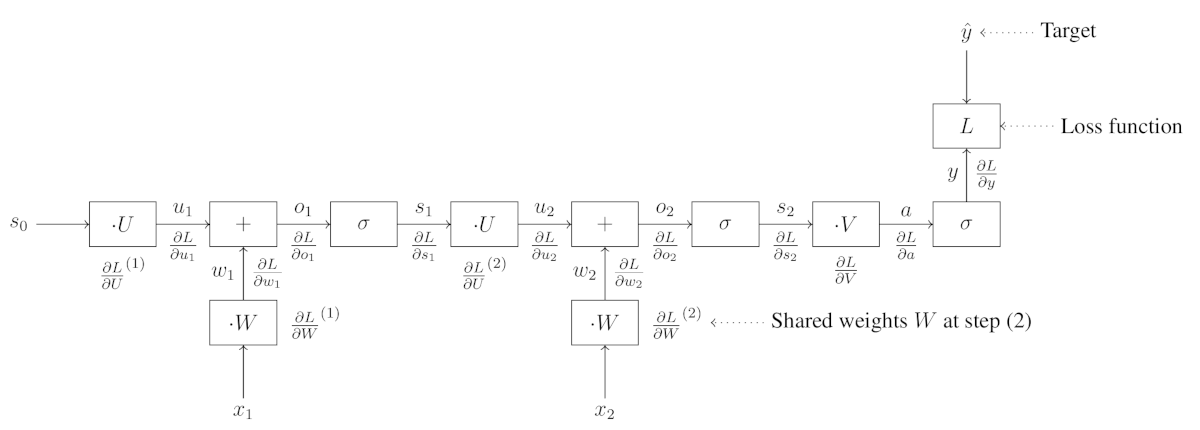)

Remember that BPTT is only Backpropagation on an unrolled recurrent neural network!

The network takes sequences as input of length $l=2$. Every element in the sequence shall be a row vector $x_i \in \mathbb{R}^{1 \times 3}$.
For the sake of simplicity, the target value of the network is a scalar $\hat{y}, y \in \mathbb{R}$ and the internal state has a size of 2, that is $s_i \in \mathbb{R}^{1 \times 2}$.
Furthermore, we use $L(y, \hat{y}) = \frac{1}{2}(y - \hat{y})^2$ as a loss function.
We use sigmoid as the activation function.

a) You can infer the shape of all learnable parameters from the above information.
What are the shapes of U, W and V ?

b) Derive the formula for every partial derivative annotated in the graph above by applying backpropagation.
Remember that the matrices $W$ and $U$ are shared between inputs $x_i$.
The partial derivatives for these matrices have been annotated with the step $i$, e.g. $\frac{\partial L}{\partial W}^{(i)}$, to help differentiate between steps $i$.



Credit: This exercise is based on Andrej Karpathy's minimal character-level Vanilla RNN model and this blog post http://karpathy.github.io/2015/05/21/rnn-effectiveness/

### 1. What are the advantages of LSTM and GRU over Vanilla RNN?

Avoid gradient vanishing and exploading. Saving long term dependencies.

### 2. Name 2 key differences between a recurrent neural network that processes inputs of length $l=3$ and a fully-connected network that has three layers!

- RNN shares parameters
- the context is explicitm not only included into the previous layers

### 3. Unfolded RNN.

#### Weights sizes:
- U: (2, 2)
- W: (3, 2)
- V: (2, 1)

#### Backprop formulas

$$
\begin{align*}
\frac{\partial L}{\partial y} &= y - \hat{y} \\
\frac{\partial L}{\partial a} &= \frac{\partial L}{\partial y} \frac{\partial y}{\partial a} = \frac{\partial L}{\partial y} y (1 - y) \\
\frac{\partial L}{\partial V} &= \frac{\partial L}{\partial a} \frac{\partial a}{\partial V} = \frac{\partial L}{\partial a} s_2^T \\
\frac{\partial L}{\partial s_2} &= \frac{\partial L}{\partial a} \frac{\partial a}{\partial s_2} = \frac{\partial L}{\partial y} V^T \\
\frac{\partial L}{\partial o_2} &= \frac{\partial L}{\partial s_2} \frac{\partial s_2}{\partial o_2} = \frac{\partial L}{\partial s_2} s_2 (1 - s_2) \\
\frac{\partial L}{\partial u_2} &= \frac{\partial L}{\partial o_2} \times 1 \\
\frac{\partial L}{\partial w_2} &= \frac{\partial L}{\partial o_2} \times 1 \\
\frac{\partial L}{\partial W}^{(2)} &= \frac{\partial L}{\partial w_2} \frac{\partial w_2}{\partial W} = \frac{\partial L}{\partial w_2} x_2^T \\
\frac{\partial L}{\partial U}^{(2)} &= \frac{\partial L}{\partial u_2} \frac{\partial u_2}{\partial U} = \frac{\partial L}{\partial u_2} s_1^T \\
\frac{\partial L}{\partial s_1} &= \frac{\partial L}{\partial u_2} U^T \\
\frac{\partial L}{\partial o_1} &= \frac{\partial L}{\partial s_1} s_1 (1 - s_1) \\
\frac{\partial L}{\partial u_1} &= \frac{\partial L}{\partial o_1} \\ 
\frac{\partial L}{\partial w_1} &= \frac{\partial L}{\partial o_1} \\ 
\frac{\partial L}{\partial W} ^ {(1)} &= \frac{\partial L}{\partial w_1} x_1^T \\
\frac{\partial L}{\partial U} ^ {(1)} &= \frac{\partial L}{\partial u_1} _0^T
\end{align*}
$$